In [2]:
!pip install zipline-reloaded pyfolio-reloaded pandas numpy matplotlib

import platform
print(platform.python_version())

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 64.7 MB/s eta 0:00:00:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 87.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 71.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 67.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.4/198.4 kB 9.4 MB/s eta 0:00:00
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26097 sha256=fc2e061f482f09258e4d0703d262969b5d6beb95ff2500d177df3a68a4ac6a8f
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
  Created wheel for python-interface: filename=python_interface-1.6.1-py3-none-a

In [3]:
import os

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
QUANDL_API_KEY = user_secrets.get_secret("quandl_api_key")
os.environ['QUANDL_API_KEY'] = QUANDL_API_KEY

In [4]:
!zipline ingest -b quandl
!zipline bundles

/usr/local/lib/python3.10/dist-packages/zipline/data/bundles/quandl.py:107: FutureWarning: The provided callable <function min at 0x7c2e33345a20> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  data = data.groupby(by="symbol").agg({"date": [np.min, np.max]})
/usr/local/lib/python3.10/dist-packages/zipline/data/bundles/quandl.py:107: FutureWarning: The provided callable <function max at 0x7c2e33345900> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  data = data.groupby(by="symbol").agg({"date": [np.min, np.max]})
Merging daily equity files:  [--------#---------------------------]  1731/usr/local/lib/python3.10/dist-packages/zipline/data/bcolz_daily_bars.py:341: UserWarning: Ignoring 1 values because they are out of bounds for uint32:
         

<ipython-input-30-b22c78755db2>:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  perf = (ts[-1] / ts[0]) - 1
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9.606%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2003-01-02
End date,2017-12-29
Total months,179
,Backtest
Annual return,9.606%
Cumulative returns,295.256%
Annual volatility,18.176%
Sharpe ratio,0.60
Calmar ratio,0.17
Stability,0.78
Max drawdown,-58.17%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,58.17,2007-10-31,2009-03-09,2013-03-22,1408
1,12.98,2015-07-16,2015-08-25,2016-03-11,172
2,11.09,2004-03-05,2004-08-06,2004-10-06,154
3,10.16,2007-07-19,2007-08-16,2007-10-29,73
4,10.00,2003-01-06,2003-03-11,2003-03-21,55


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


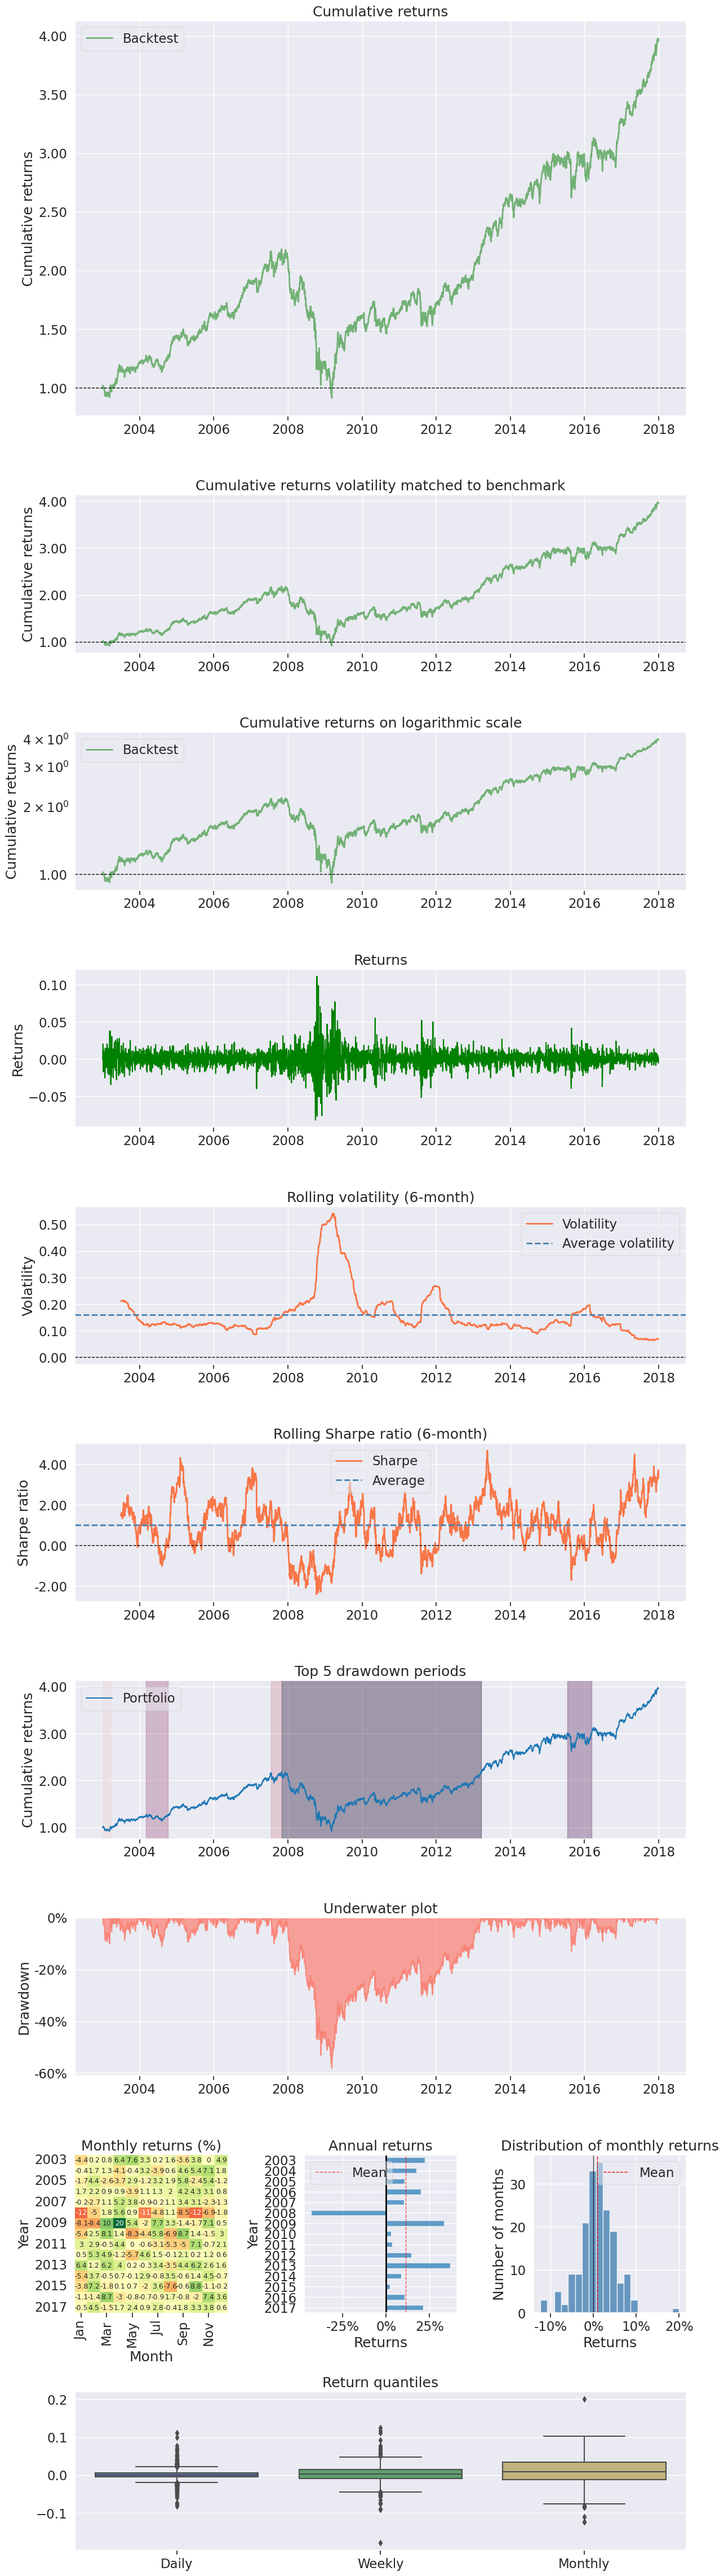

In [30]:
import pandas as pd
import pyfolio as pf
import pytz
import matplotlib.pyplot as plt
from zipline import run_algorithm
from datetime import datetime

from zipline.api import order_target_percent, symbol, schedule_function, date_rules, time_rules

def initialize(context):
    # Which stock to trade
    dji = [
        "AAPL",
        "AXP",
        "BA",
        "CAT",
        "CSCO",
        "CVX",
        "DIS",
        "DWDP",
        "GS",
        "HD",
        "IBM",
        "INTC",
        "JNJ",
        "JPM",
        "KO",
        "MCD",
        "MMM",
        "MRK",
        "MSFT",
        "NKE",
        "PFE",
        "PG",
        "TRV",
        "UNH",
        "UTX",
        "V",
        "VZ",
        "WBA",
        "WMT",
        "XOM",  
    ]
    # Make symbol list from tickers
    context.universe = [symbol(s) for s in dji]
    
    # History window
    context.history_window = 20
    
    # Size of our portfolio
    context.stocks_to_hold = 10
    
    # Schedule the daily trading routine for once per month
    schedule_function(handle_data, date_rules.month_start(), time_rules.market_close())
    
def month_perf(ts):
    perf = (ts[-1] / ts[0]) - 1
    return perf
    
def handle_data(context, data):
    # Get history for all the stocks.
    hist = data.history(context.universe, "close", context.history_window, "1d")

    # This creates a table of percent returns, in order.
    perf_table = hist.apply(month_perf).sort_values(ascending=False)
    
    # Make buy list of the top N stocks
    buy_list = perf_table[:context.stocks_to_hold]
    
    # The rest will not be held.
    the_rest = perf_table[context.stocks_to_hold:]
    
    # Place target buy orders for top N stocks.
    for stock, perf in buy_list.items():
        stock_weight = 1 / context.stocks_to_hold

        # Place order
        if data.can_trade(stock):
            order_target_percent(stock, stock_weight)

    # Make sure we are flat the rest.
    for stock, perf in the_rest.items():
        # Place order
        if data.can_trade(stock):
            order_target_percent(stock, 0.0)    

def analyze(context, perf):
    # Use PyFolio to generate a performance report
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    pf.create_returns_tear_sheet(returns, benchmark_rets=None)

# Set start and end date
start_date = pd.Timestamp('2003-01-01')
end_date = pd.Timestamp('2017-12-31')

# Fire off the backtest
results = run_algorithm(
    start=start_date, 
    end=end_date, 
    initialize=initialize, 
    analyze=analyze,
    capital_base=10000, 
    data_frequency = 'daily', bundle='quandl'
)

algo_volatility                                                     0.211013
algorithm_period_return                                             0.061212
alpha                                                                   None
benchmark_period_return                                                  0.0
benchmark_volatility                                                     0.0
beta                                                                    None
capital_used                                                             0.0
ending_cash                                                       -29.424954
ending_exposure                                                     10641.54
ending_value                                                        10641.54
excess_return                                                            0.0
gross_leverage                                                      1.002773
long_exposure                                                       10641.54

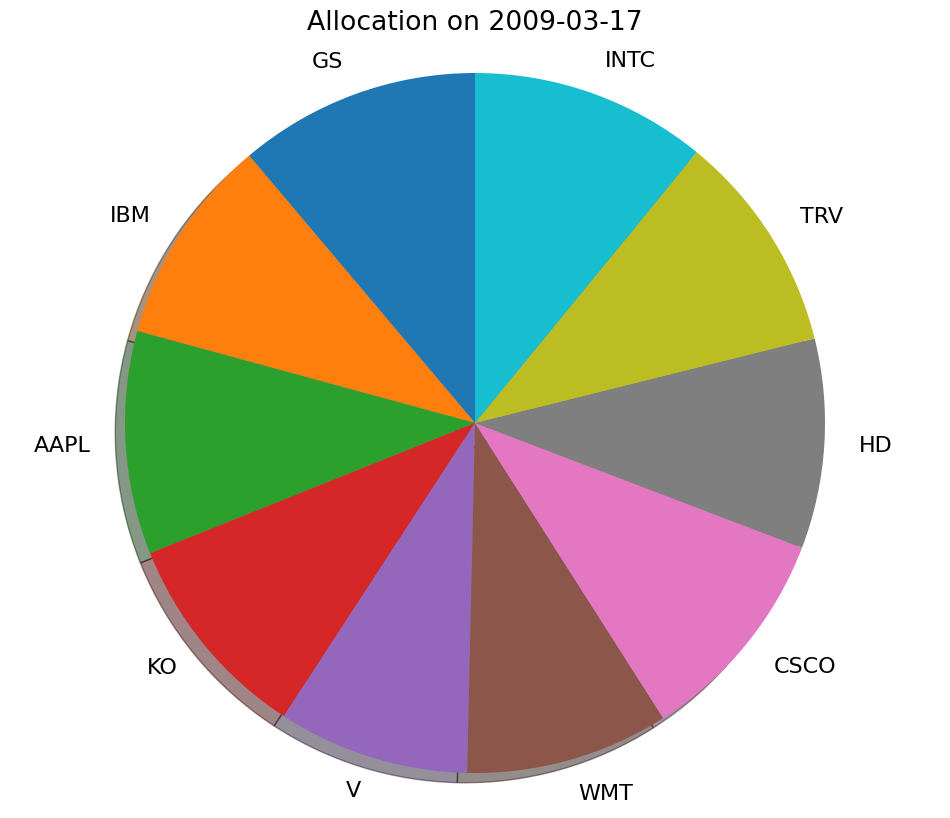

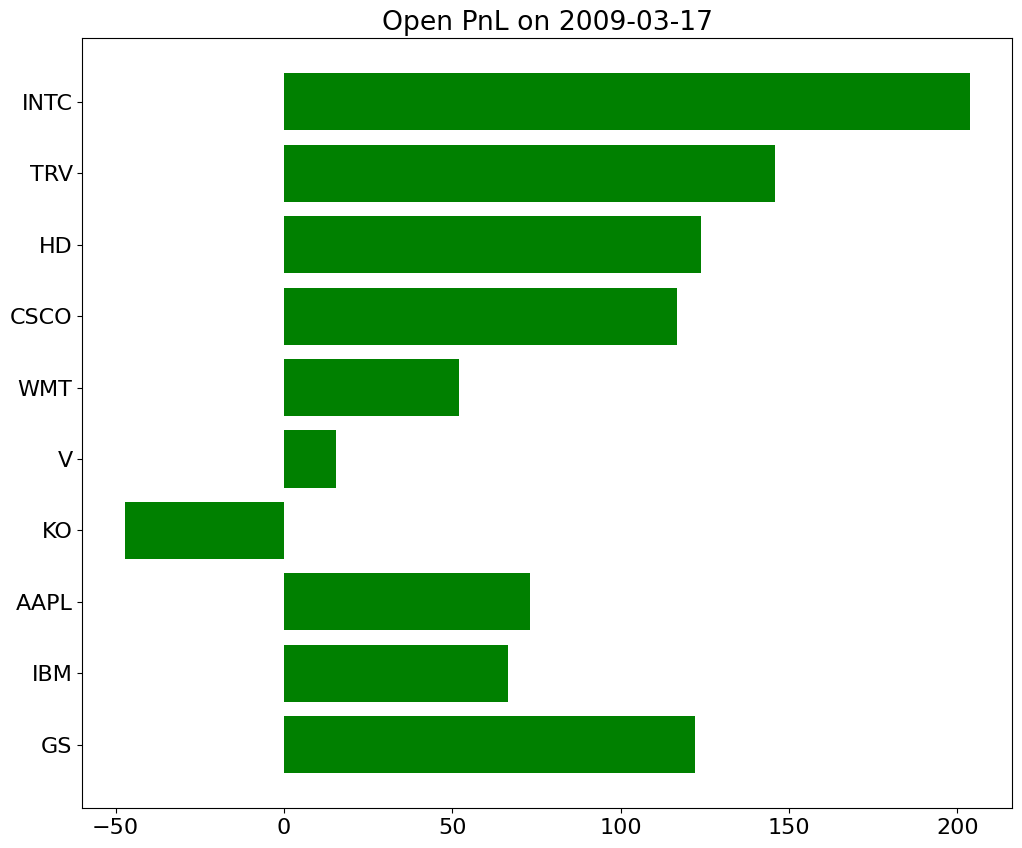

In [31]:
# Let's get a portfolio snapshot
# Import pandas and matplotlib
import pandas as pd
import matplotlib.pyplot as plt

# Select day to view
day = '2009-03-17'

# Get portfolio value and positions for this day
port_value = results.loc[day,'portfolio_value']
day_positions = results.loc[day,'positions']
print(results.loc[day].sort_index())

# Empty DataFrame to store values
df = pd.DataFrame(columns=['value', 'pnl'])

# Populate DataFrame with position info
for pos in day_positions:
    ticker = pos['sid'].symbol 
    df.loc[ticker,'value'] = pos['amount'] * pos['last_sale_price']
    df.loc[ticker,'pnl'] = df.loc[ticker,'value'] - (pos['amount'] * pos['cost_basis'])

# Make pie chart for allocations
fig, ax1 = plt.subplots(figsize=[12, 10])
ax1.pie(df['value'], labels=df.index, shadow=True, startangle=90)
ax1.axis('equal')
ax1.set_title('Allocation on {}'.format(day))
plt.show()

# Make bar chart for open PnL
fig, ax1 = plt.subplots(figsize=[12, 10])
ax1.barh( df.index, df['pnl'],  align='center', color='green', ecolor='black')
ax1.set_title('Open PnL on {}'.format(day))
plt.show()

<ipython-input-32-12da11359908>:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.power((ts[-1] / ts[0]), (year_length/len(ts))) -1


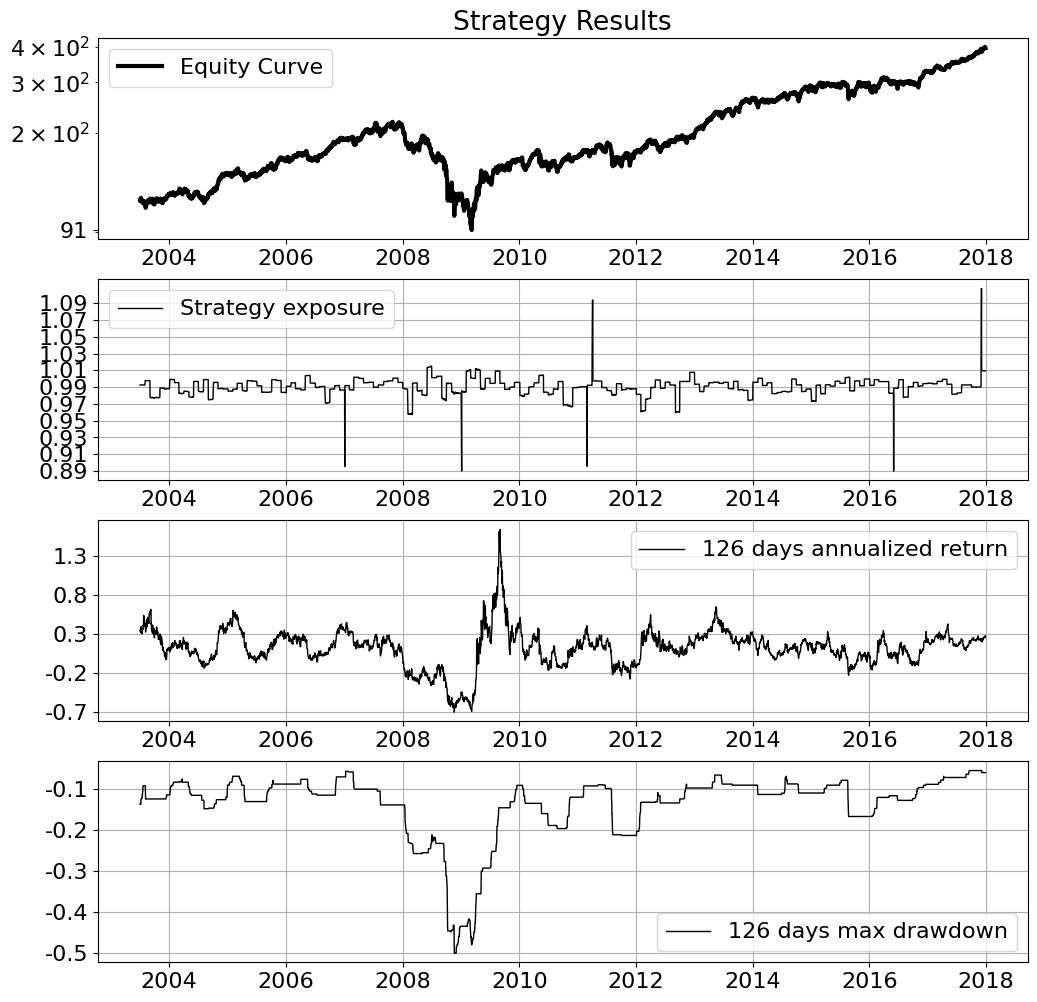

In [32]:
# Custom Time Series Analysis

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt, rc, ticker

# Format for book image
font = {'family' : 'eurostile',
        'weight' : 'normal',
        'size'   : 16}
rc('font', **font)

# Settings
calc_window = 126
year_length = 252

# Copy the columns we need
df = results.copy().filter(items=['portfolio_value', 'gross_leverage'])

# Function for annualized return
def ann_ret(ts):
    return np.power((ts[-1] / ts[0]), (year_length/len(ts))) -1  

# Function for drawdown
def dd(ts):
    return np.min(ts / np.maximum.accumulate(ts)) - 1

# Get a rolling window
rolling_window = results.portfolio_value.rolling(calc_window)

# Calculate rolling analytics
df['annualized'] = rolling_window.apply(ann_ret)
df['drawdown'] = rolling_window.apply(dd)

# Drop initial n/a values
df.dropna(inplace=True)

# Make a figure
fig = plt.figure(figsize=(12, 12))

# Make the base lower, just to make the graph easier to read
df['portfolio_value'] /= 100

# First chart
ax = fig.add_subplot(411)
ax.set_title('Strategy Results')
ax.plot(df['portfolio_value'], 
        linestyle='-', 
        color='black',
        label='Equity Curve', linewidth=3.0)

# Set log scale
ax.set_yscale('log') 

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['portfolio_value'].min(), df['portfolio_value'].max(), 500 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))

# Add legend and grid
ax.legend()
ax.grid(False)

# Second chart
ax = fig.add_subplot(412)
ax.plot(df['gross_leverage'], 
        label='Strategy exposure'.format(calc_window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['gross_leverage'].min(), df['gross_leverage'].max(), 0.02 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Add legend and grid
ax.legend()
ax.grid(True)

# Third chart
ax = fig.add_subplot(413)
ax.plot(df['annualized'], 
        label='{} days annualized return'.format(calc_window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['annualized'].min(), df['annualized'].max(), 0.5 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

# Add legend and grid
ax.legend()
ax.grid(True)

# Fourth chart
ax = fig.add_subplot(414)
ax.plot(df['drawdown'], 
        label='{} days max drawdown'.format(calc_window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['drawdown'].min(), df['drawdown'].max(), 0.1 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

# Add legend and grid
ax.legend()
ax.grid(True)